<a href="https://colab.research.google.com/github/moon2su/ML-programming/blob/main/WISDM_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from pandas import read_csv, unique

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from keras.layers import Conv1D, LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [ ]:
names = ['user-id', 'activity', 'timestamp', 'X', 'Y', 'Z', "NaN"]

data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt", header=None, names=names, comment=";")

def convert_to_float(x):
    try:
        return np.float64(x)
    except:
        return np.nan

df = data.drop('NaN', axis=1)
df["Z"].replace(regex = True, inplace = True, to_replace = r';', value = r'')

df["Z"] = df["Z"].apply(convert_to_float)

df.dropna(axis=0, how='any', inplace=True)
df.head()

,user-id,activity,timestamp,X,Y,Z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


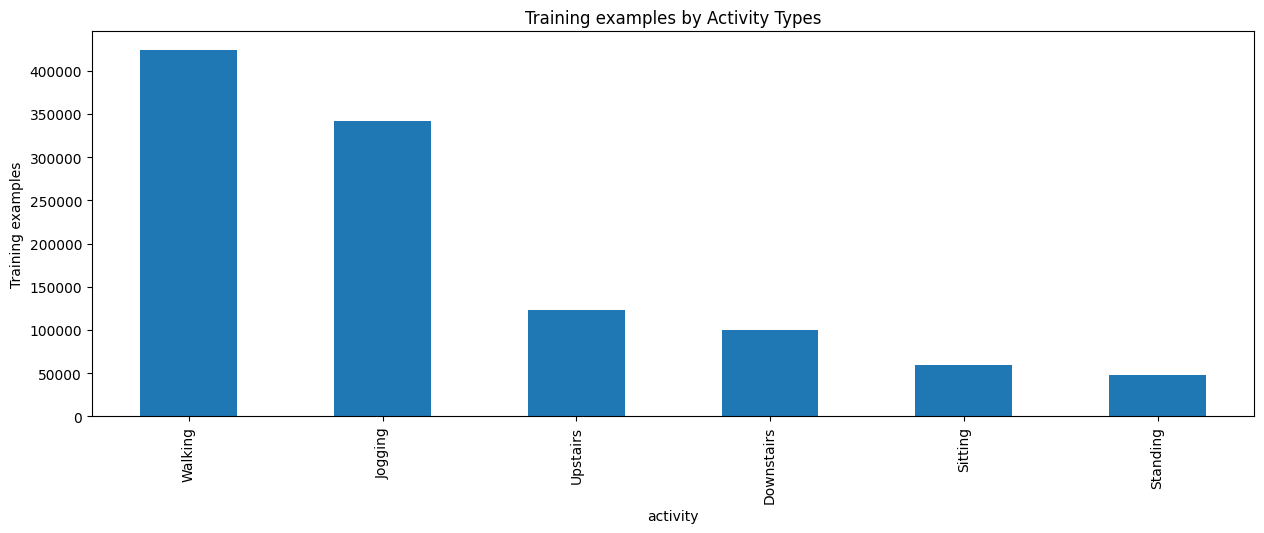

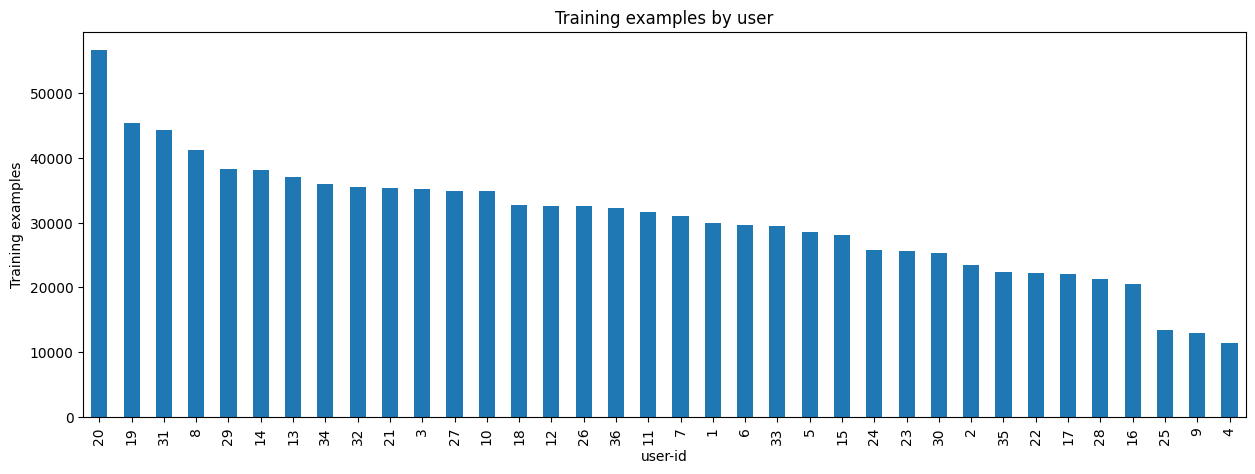

In [ ]:
plt.figure(figsize=(15, 5))

plt.xlabel('Activity Type')
plt.ylabel('Training examples')
df['activity'].value_counts().plot(kind='bar',
                                  title='Training examples by Activity Types')
plt.show()

plt.figure(figsize=(15, 5))
plt.xlabel('User')
plt.ylabel('Training examples')
df['user-id'].value_counts().plot(kind='bar',
                                 title='Training examples by user')
plt.show()

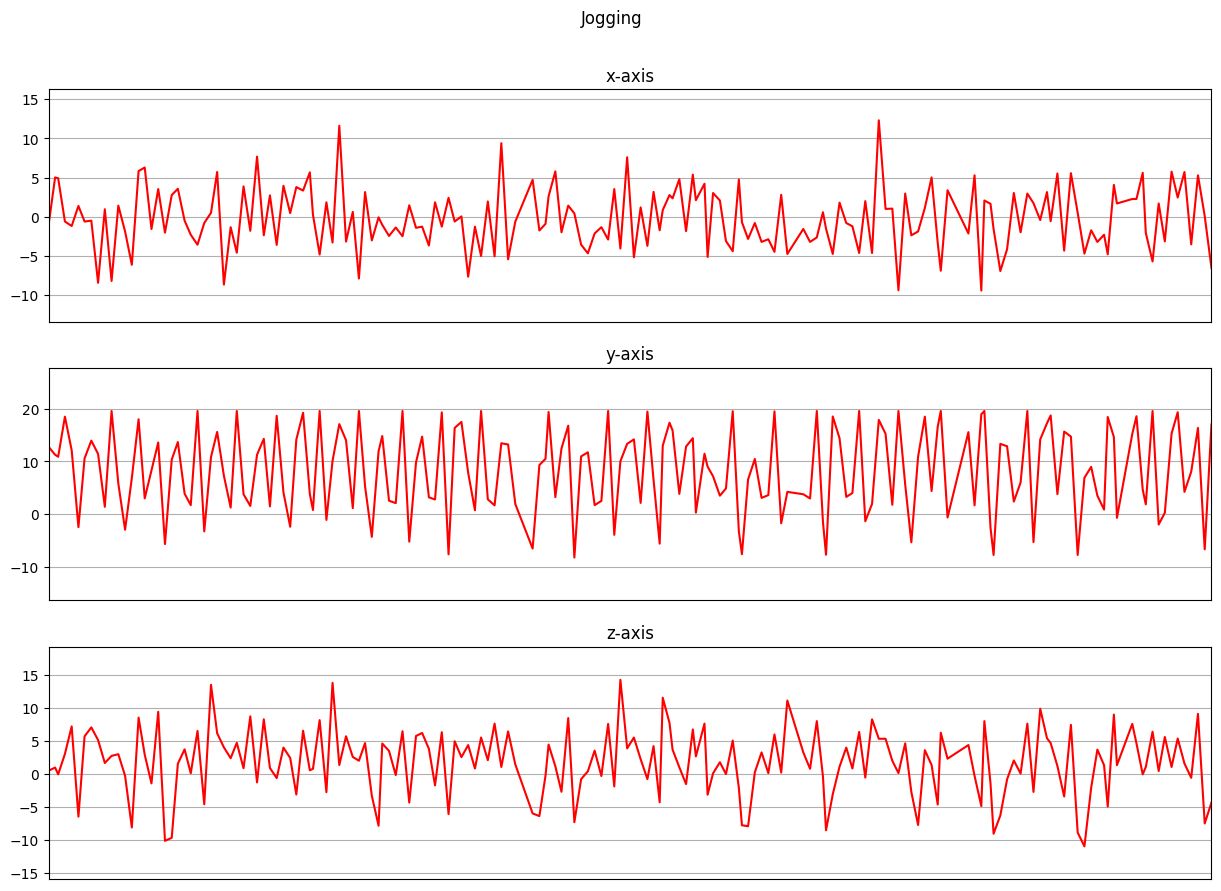

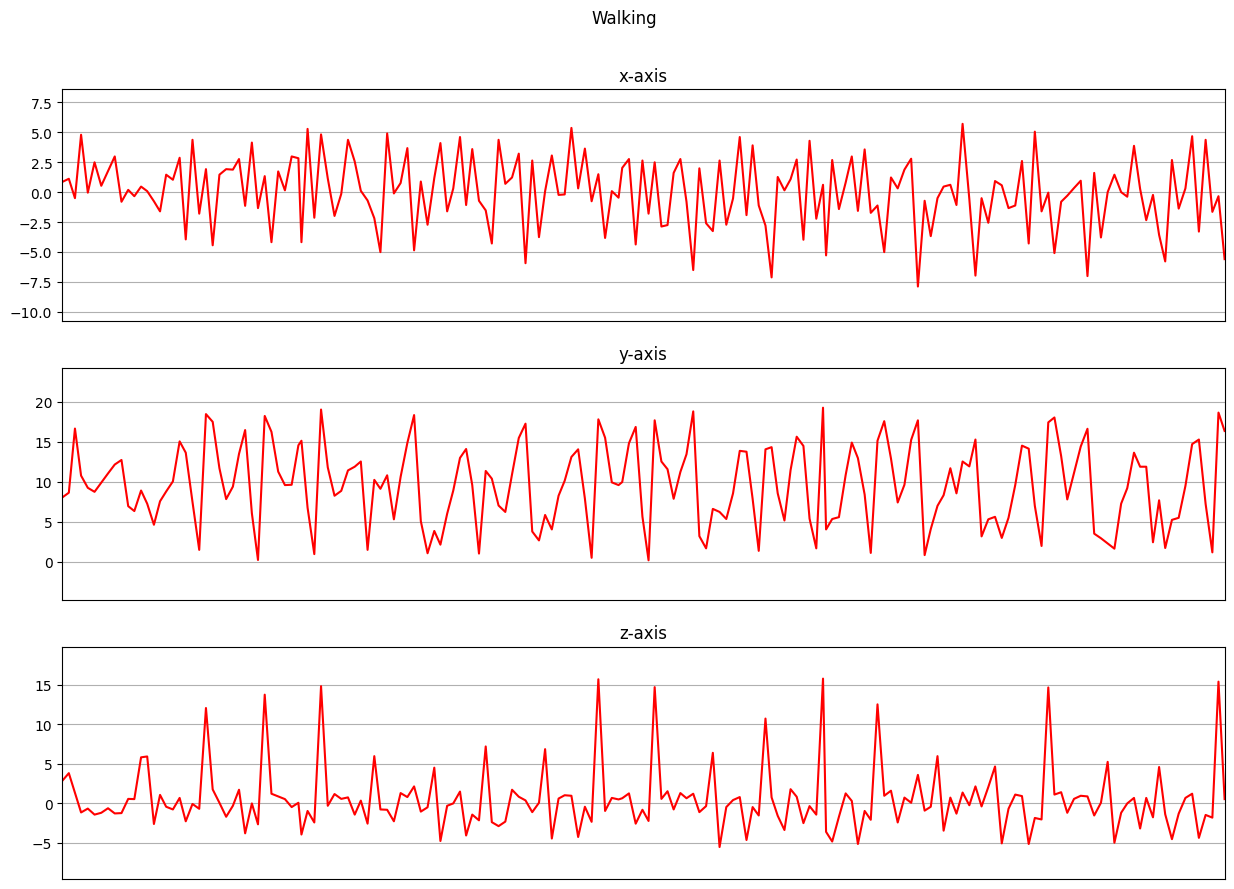

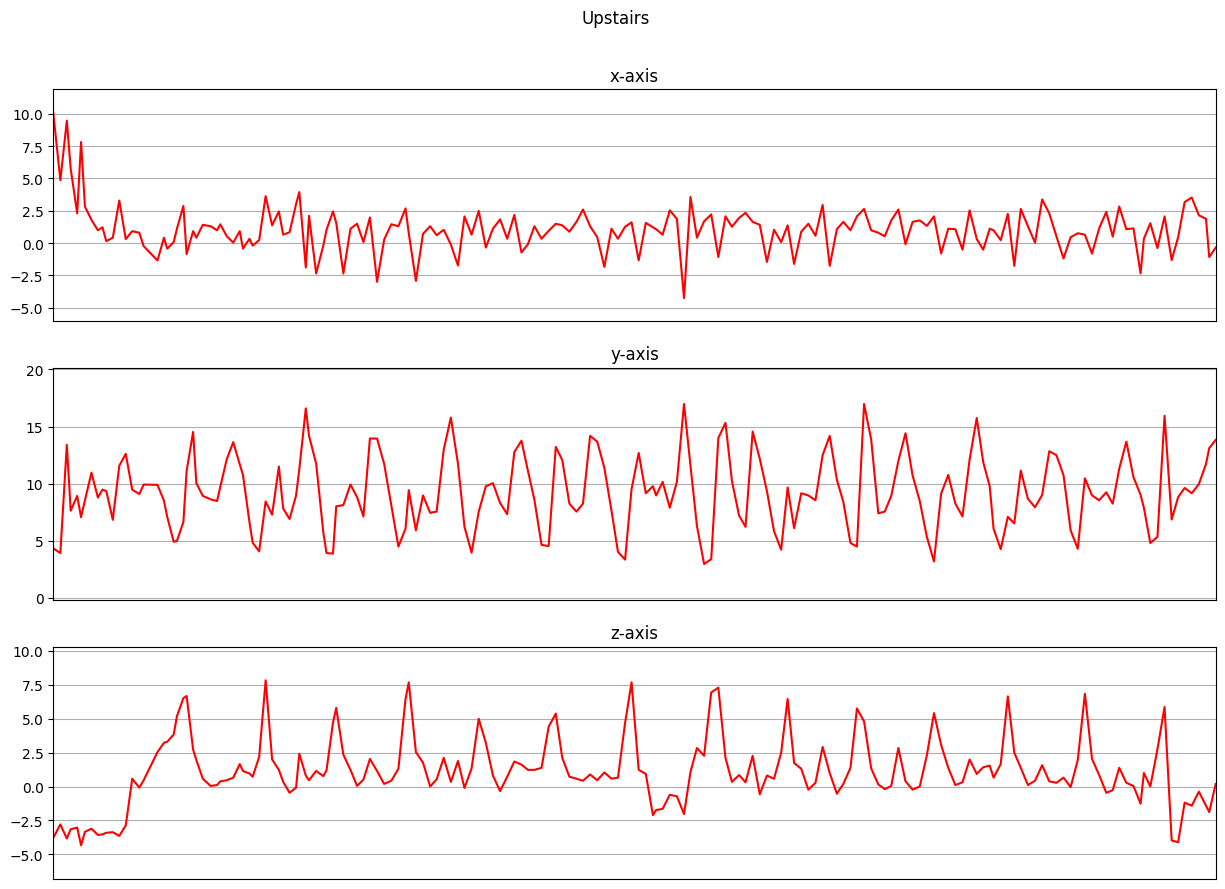

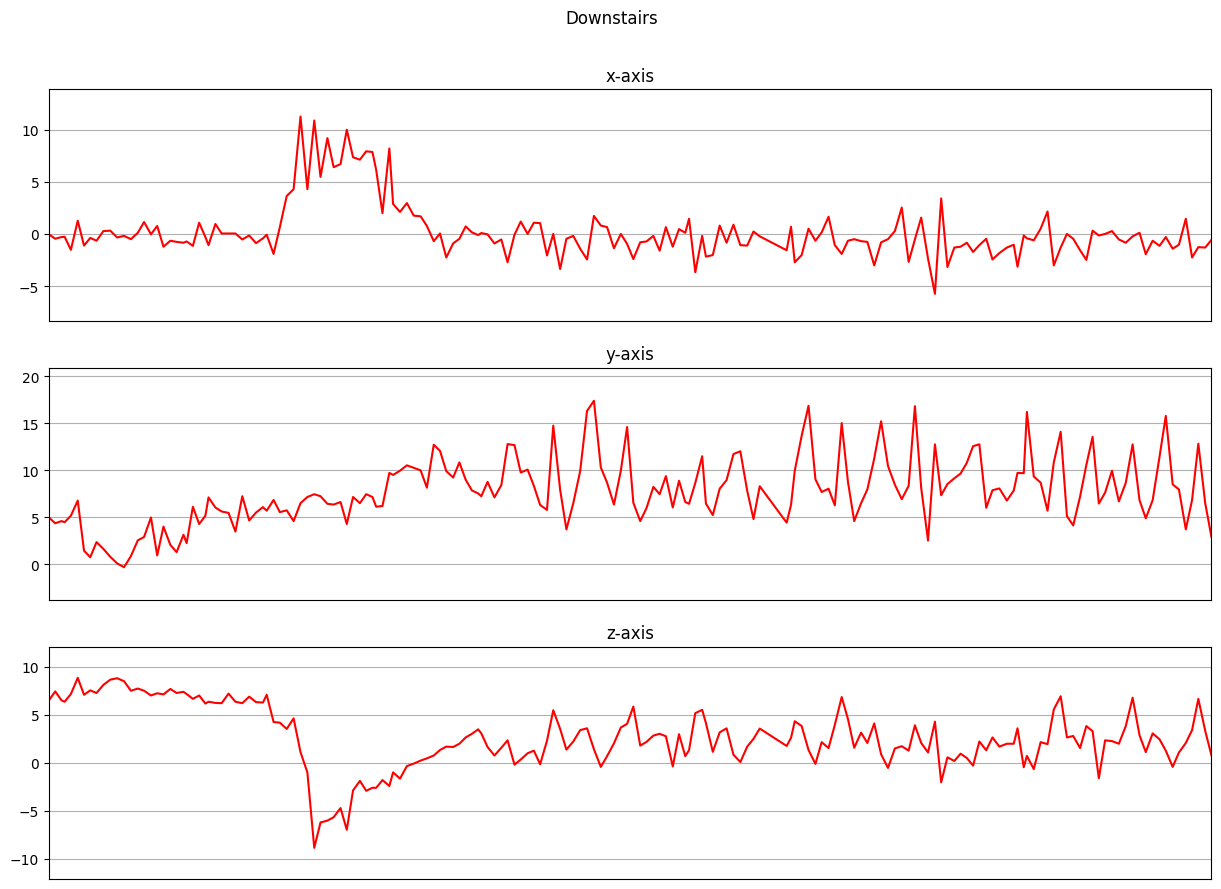

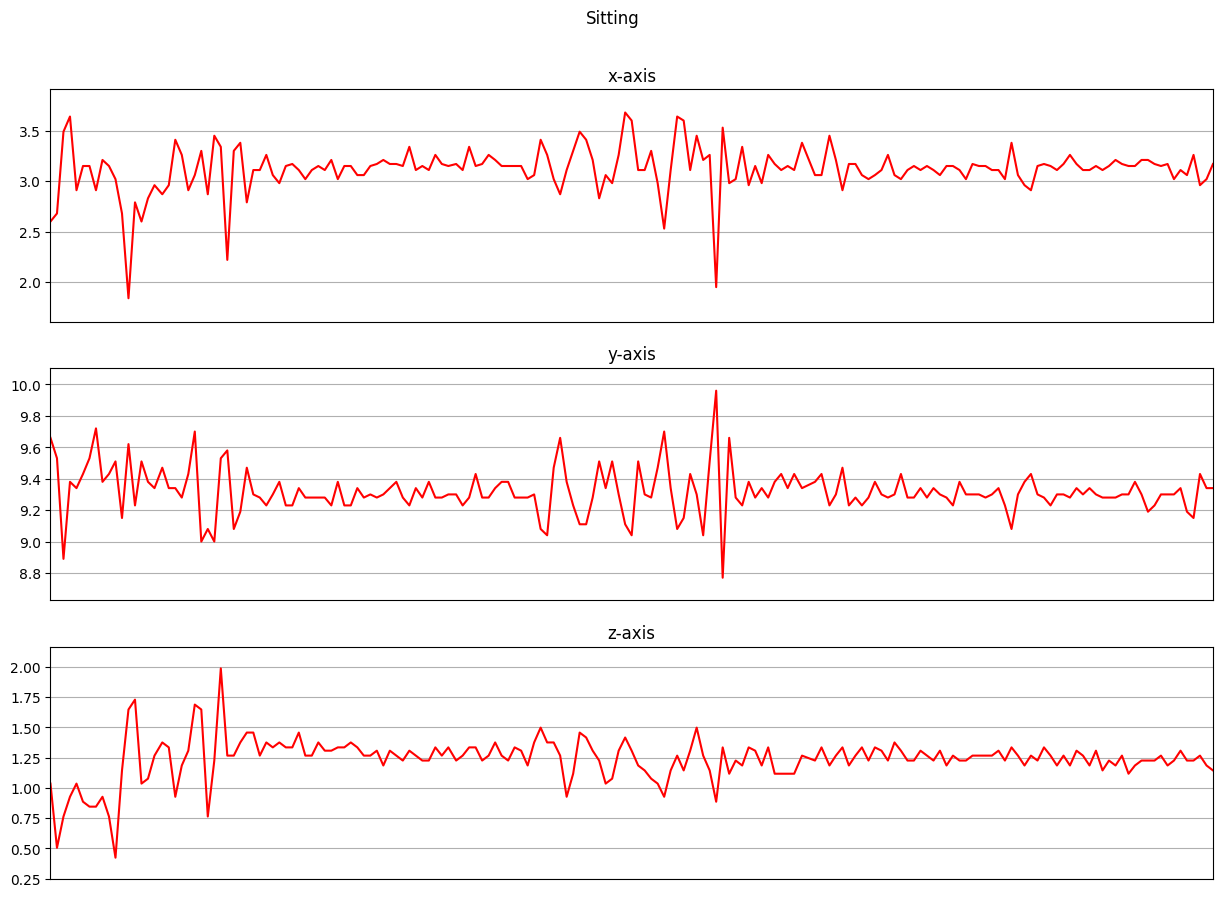

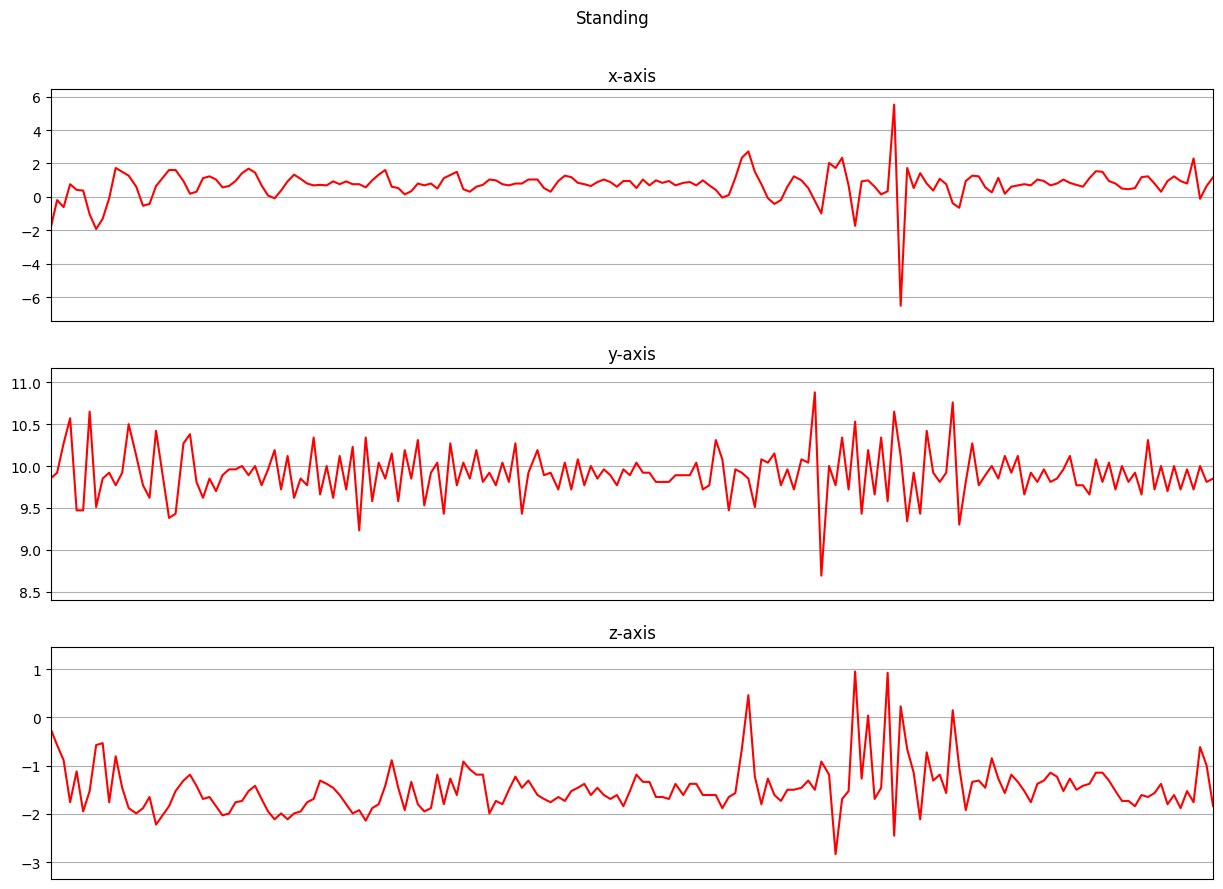

In [ ]:
  def axis_plot(ax, x, y, title):
    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in df['activity'].unique():
    limit = df[df['activity'] == activity][:180]
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharex=True, figsize=(15, 10))
    axis_plot(ax0, limit['timestamp'], limit['X'], 'x-axis')
    axis_plot(ax1, limit['timestamp'], limit['Y'], 'y-axis')
    axis_plot(ax2, limit['timestamp'], limit['Z'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.9)
    plt.show()

In [ ]:

label_encode = LabelEncoder()
df['activityEncode'] = label_encode.fit_transform(df['activity'].values.ravel())
df

,user-id,activity,timestamp,X,Y,Z,activityEncode
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,1
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,1
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,1
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,1
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,1
...,...,...,...,...,...,...,...
1098199,19,Sitting,131623331483000,9.000000,-1.570000,1.690000,2
1098200,19,Sitting,131623371431000,9.040000,-1.460000,1.730000,2
1098201,19,Sitting,131623411592000,9.080000,-1.380000,1.690000,2
1098202,19,Sitting,131623491487000,9.000000,-1.460000,1.730000,2


In [ ]:
interpolation_fn = interp1d(df['activityEncode'] ,df['Z'], kind='linear')
null_list = df[df['Z'].isnull()].index.tolist()
for i in null_list:
    y = df['activityEncode'][i]
    value = interpolation_fn(y)
    df['Z']=df['Z'].fillna(value)
    print(value)

In [ ]:
## train split users between 1 and 27, test split users between 28 and 33
df_test = df[df['user-id'] > 27]
df_train = df[df['user-id'] <= 27]

In [ ]:
df_train['X'] = (df_train['X']-df_train['X'].min())/(df_train['X'].max()-df_train['X'].min())
df_train['Y'] = (df_train['Y']-df_train['Y'].min())/(df_train['Y'].max()-df_train['Y'].min())
df_train['Z'] = (df_train['Z']-df_train['Z'].min())/(df_train['Z'].max()-df_train['Z'].min())
df_train

,user-id,activity,timestamp,X,Y,Z,activityEncode
8489,17,Walking,57869902574000,0.510163,0.741908,0.488932,5
8490,17,Walking,57870012316000,0.495703,0.751526,0.487895,5
8491,17,Walking,57870122301000,0.489850,0.742938,0.484785,5
8492,17,Walking,57870222246000,0.499490,0.748778,0.489623,5
8493,17,Walking,57870332292000,0.499490,0.750496,0.486858,5
...,...,...,...,...,...,...,...
1098199,19,Sitting,131623331483000,0.723205,0.454981,0.545293,2
1098200,19,Sitting,131623371431000,0.724216,0.457755,0.546308,2
1098201,19,Sitting,131623411592000,0.725228,0.459773,0.545293,2
1098202,19,Sitting,131623491487000,0.723205,0.457755,0.546308,2


In [ ]:
def segments(df, time_steps, step, label_name):
    N_FEATURES = 3
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['X'].values[i:i+time_steps]
        ys = df['Y'].values[i:i+time_steps]
        zs = df['Z'].values[i:i+time_steps]

        label = df[label_name].iloc[i:i+time_steps].mode().iloc[0]
        segments.append([xs, ys, zs])
        labels.append(label)

    reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

TIME_PERIOD = 80
STEP_DISTANCE = 40
LABEL = 'activityEncode'
x_train, y_train = segments(df_train, TIME_PERIOD, STEP_DISTANCE, LABEL)

print('x_train shape:', x_train.shape)
print('Training samples:', x_train.shape[0])
print('y_train shape:', y_train.shape)

x_train shape: (20334, 80, 3)
Training samples: 20334
y_train shape: (20334,)


In [ ]:
## Input and Output Dimensions
time_period, sensors = x_train.shape[1], x_train.shape[2]
num_classes = label_encode.classes_.size
print(list(label_encode.classes_))

['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']


In [ ]:
## reshaping data
input_shape = time_period * sensors
x_train = x_train.reshape(x_train.shape[0], input_shape)
print("Input Shape: ", input_shape)
print("Input Data Shape: ", x_train.shape)

Input Shape:  240
Input Data Shape:  (20334, 240)


In [ ]:
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

y_train_hot = to_categorical(y_train, num_classes)
print("y_train shape: ", y_train_hot.shape)

y_train shape:  (20334, 6)


In [ ]:
# LSTM Model
Lmodel = Sequential()
Lmodel.add(LSTM(32, return_sequences=True, input_shape=(input_shape,1), activation='relu'))
Lmodel.add(LSTM(32,return_sequences=True, activation='relu'))
Lmodel.add(MaxPool1D(pool_size=4, padding='same'))
Lmodel.add(GlobalAveragePooling1D())
Lmodel.add(BatchNormalization(epsilon=1e-06))
Lmodel.add(Dense(6))
Lmodel.add(Activation('softmax'))

print(Lmodel.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 240, 32)        │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 240, 32)        │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 60, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           198 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 6)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,998 (50.77 KB)

 Trainable params: 12,934 (50.52 KB)

 Non-trainable params: 64 (256.00 B)

None


In [ ]:
Lmodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = Lmodel.fit(x_train,
                    y_train_hot,
                    batch_size= 192,
                    epochs=50
                   )

Epoch 1/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 47s 396ms/step - accuracy: 0.7625 - loss: 0.6207
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 39s 369ms/step - accuracy: 0.7856 - loss: 0.5196
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 40s 361ms/step - accuracy: 0.8017 - loss: 0.4865
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 40s 350ms/step - accuracy: 0.8229 - loss: 0.4455
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 39s 363ms/step - accuracy: 0.8269 - loss: 0.4408
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 45s 400ms/step - accuracy: 0.8396 - loss: 0.4113
Epoch 7/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 78s 367ms/step - accuracy: 0.8571 - loss: 0.3784
Epoch 8/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 38s 359ms/step - accuracy: 0.8708 - loss: 0.3590
Epoch 9/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 40s 354ms/step - accuracy: 0.8666 - loss: 0.3536
Epoch 10/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 41s 351ms/step - accuracy: 0.8784 - loss: 0.3280
Epoch 11/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 41s 352ms/step - accuracy: 0.8787 - loss: 0.3253
Epoch 12/50
106/106

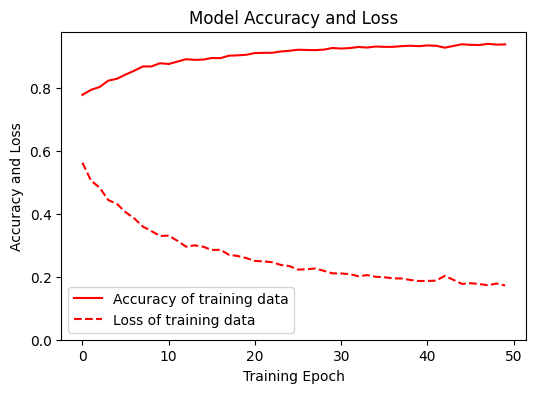

636/636 ━━━━━━━━━━━━━━━━━━━━ 36s 56ms/step
              precision    recall  f1-score   support

         0.0       0.73      0.56      0.63      1788
         1.0       1.00      0.94      0.97      6569
         2.0       1.00      0.64      0.78      1049
         3.0       0.68      1.00      0.81       801
         4.0       0.56      0.96      0.71      2269
         5.0       0.98      0.87      0.92      7858

    accuracy                           0.87     20334
   macro avg       0.82      0.83      0.80     20334
weighted avg       0.90      0.87      0.88     20334



In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

y_pred_train = Lmodel.predict(x_train)
max_y_pred_train = np.argmax(y_pred_train, axis=1)
print(classification_report(y_train, max_y_pred_train))

In [ ]:
df_test['X'] = (df_test['X']-df_test['X'].min())/(df_test['X'].max()-df_test['X'].min())
df_test['Y'] = (df_test['Y']-df_test['Y'].min())/(df_test['Y'].max()-df_test['Y'].min())
df_test['Z'] = (df_test['Z']-df_test['Z'].min())/(df_test['Z'].max()-df_test['Z'].min())
x_test, y_test = segments(df_test,
                         TIME_PERIOD,
                         STEP_DISTANCE,
                         LABEL)

x_test = x_test.reshape(x_test.shape[0], input_shape)
x_test = x_test.astype('float32')
y_test = y_test.astype('float32')
y_test = to_categorical(y_test, num_classes)

In [ ]:
score = Lmodel.evaluate(x_test, y_test)
print("Accuracy:", score[1])
print("Loss:", score[0])

223/223 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.8073 - loss: 0.7195
Accuracy: 0.7932003140449524
Loss: 0.684066891670227


223/223 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step


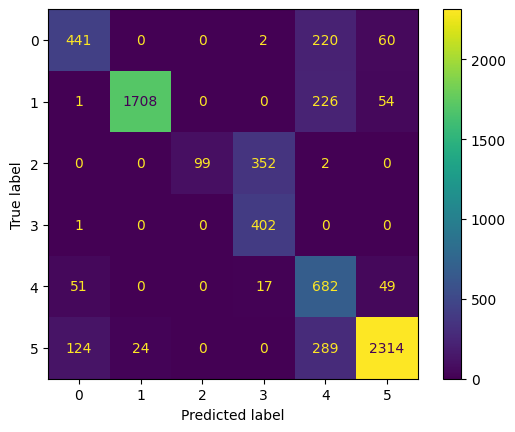

In [ ]:
predictions = Lmodel.predict(x_test)
predictions = np.argmax(predictions, axis=1)
y_test_pred = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test_pred, predictions)
cm_disp = ConfusionMatrixDisplay(confusion_matrix= cm)
cm_disp.plot()
plt.show()

In [ ]:
print(classification_report(y_test_pred, predictions))

              precision    recall  f1-score   support

           0       0.71      0.61      0.66       723
           1       0.99      0.86      0.92      1989
           2       1.00      0.22      0.36       453
           3       0.52      1.00      0.68       403
           4       0.48      0.85      0.61       799
           5       0.93      0.84      0.89      2751

    accuracy                           0.79      7118
   macro avg       0.77      0.73      0.69      7118
weighted avg       0.86      0.79      0.80      7118

